# Regression Analysis of C-Peptide Dependence on Age and Base Deficit

## INTRO AND SUMMARY GOES HERE

## Methods

### Question: 
When studying patterns of insulin-dependent diabetes mellitus in children, is there a relationship between levels of serum C-Peptide and the factors of patient age and base deficit?

### Data Source:
KEEL Diabetes Data Set

The data was sourced from KEEL (Knowledge Extraction based on Evolutionary Learning), which is an open source software tool containing datasets that can be used for knowledge data discovery. The chosen dataset is designed for regression analysis, taken from LIACC's repository. The objective of this data is to investigate how factors such as patient age and base deficit (a measure of metabolic acidosis) are associated with concentration of C-peptide, in order to further understand patterns of insulin-resistant Diabetes Mellitus in children.

KEEL Diabetes Dataset (By KEEL). (n.d.). [Dataset]. https://sci2s.ugr.es/keel/dataset.php?cod=45

### Data Structure:

`Age`: Patient Age, domain: [0.9,15.6]

`Deficit`: Base Deficit, measure of acidity, domain: [-29.0,-0.2]

`C-peptide`: Logarithm of C-Peptide concentration (pmol/ml), domain: [3.0,6.6]

### Imports

In [1]:
import pandas as pd
import numpy as np
import requests
import zipfile
import os
import io
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

### Download Data into data/ directory
This code was adapted from Microsoft Copilot prompts:
'Use Python to download a data file from a download link into a directory, as a csv'

In [2]:
url = "https://sci2s.ugr.es/keel/dataset/data/regression/diabetes.zip"

file_path = os.path.join("data", "diabetes.zip")

response = requests.get(url)
zip_bytes = io.BytesIO(response.content)

with open(file_path, "wb") as f:
    f.write(response.content)


In [3]:
with zipfile.ZipFile(zip_bytes, "r") as zip_ref:
    dat_files = [f for f in zip_ref.namelist() if f.endswith(".dat")]
    dat_content = zip_ref.read(dat_files[0]).decode("utf-8")

### Data Wrangling and Cleaning
1. original file downloads as .dat, ensure it fits with a .csv format by splitting with the ',' delimiter and stripping lines beginning with '@'
2. re-name columns since names were stripped away
3. ensure data is the correct dtype

In [4]:
lines = dat_content.splitlines()
data_lines = [line for line in lines if not line.startswith("@") and line.strip()]

In [5]:
rows = [line.strip().split(",") for line in data_lines]
diabetes_df = pd.DataFrame(rows)

diabetes_df.columns = ["Age", "Deficit", "C_peptide"]
diabetes_df = diabetes_df.astype(float)

Note: dtypes were set to float manually as they were downloaded as dtype: object

In [6]:
csv_path = os.path.join("data", "diabetes.csv")
diabetes_df.to_csv(csv_path, index=False)

### EDA

In [7]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        43 non-null     float64
 1   Deficit    43 non-null     float64
 2   C_peptide  43 non-null     float64
dtypes: float64(3)
memory usage: 1.1 KB


Figure 1: Dataset summary

No null values, data types were set to float earlier

In [8]:
diabetes_df.describe()

,Age,Deficit,C_peptide
count,43.000000,43.000000,43.000000
mean,9.032558,-8.148837,4.746512
std,4.022539,7.123080,0.720565
min,0.900000,-29.000000,3.000000
25%,5.500000,-12.700000,4.450000
50%,10.400000,-7.800000,4.900000
75%,11.850000,-2.000000,5.100000
max,15.600000,-0.200000,6.600000


Figure 2: Dataset descriptive statistics

The mean patient age is 9 years old, with the maximum age being 15.6 and the minimum being 0.9. The C_peptide concentration average is about 4.75, mean Base Deficit value is -8.15 mEq/L. The standard deviation of Base Deficit is quite high, at about 7.1 mEq/L, while the standard deviations of the other two variables are within a reasonable range for their domains. This high variance could be due to the small size of the dataset.

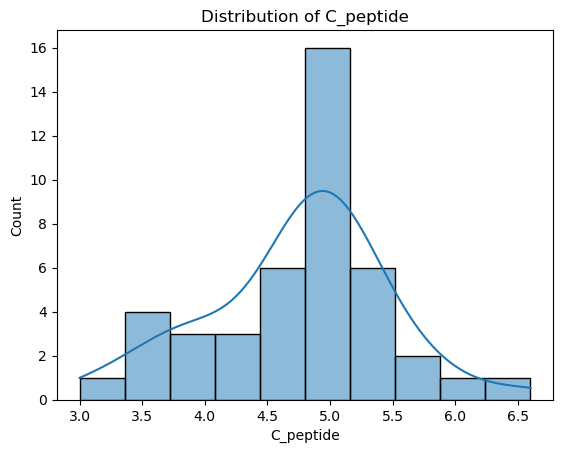

In [9]:
sns.histplot(diabetes_df["C_peptide"], kde=True)
plt.title("Distribution of C_peptide")
plt.show()

Figure 3: Distribution of target variable, C_peptide

In [10]:
alt.Chart(diabetes_df).mark_circle().encode(
    x=alt.X(alt.repeat("column"), type="quantitative"),
    y=alt.Y(alt.repeat("row"), type="quantitative")
).properties(
    width=150,
    height=150
).repeat(
    row=["Age", "Deficit", "C_peptide"],
    column=["Age", "Deficit", "C_peptide"]
)


alt.RepeatChart(...)

Figure 4: Scatterplot matrix of all variables

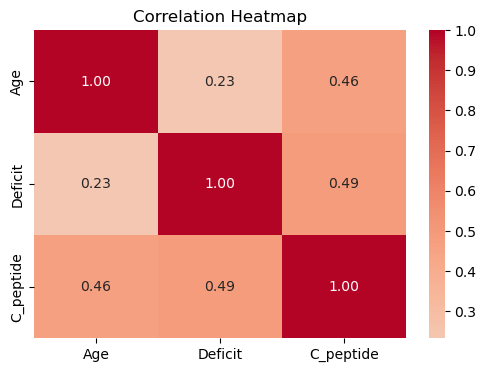

In [11]:
corr = diabetes_df.corr()


plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", center = 0, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Figure 5: Correlation heatmap of all variables

#### EDA Summary:
Both features are positively associated with the target variable, `C_peptide`, at approximately equal magnitudes (0.46 and 0.49). The distribution of the target variable is approximately normal, with most values clustered around 5.0. There does seem to be one or two outliers in scatterplots comparing the relationship between `Age` and `Deficit`, but as these are both non-target features this can be ignored for the sake of this analysis. There are no obvious outliers in the relationship between the target and its predictors.

### Modelling

We use linear regression to model the relationship between `C_peptide` and covariates `Age` and `Deficit`.

In [12]:
X = diabetes_df.drop(columns=["C_peptide"])
y = diabetes_df["C_peptide"]

In [13]:
import pingouin as pg

model = pg.linear_regression(X, y)
model

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,4.479400,0.270929,16.533455,1.765281e-19,0.368452,0.336874,3.931831,5.026968
1,Age,0.066314,0.023143,2.865386,6.608034e-03,0.368452,0.336874,0.019540,0.113088
2,Deficit,0.040726,0.013069,3.116167,3.384871e-03,0.368452,0.336874,0.014312,0.067140


Figure 6: Linear Regression Intercept and Coefficients

### Model Diagnostics

In [14]:
resid = model.residuals_

To check for Normality of residuals, we employ the Shapiro-Wilk test and Q-Q plot.

In [15]:
pg.normality(resid, method = "shapiro")

,W,pval,normal
0,0.987989,0.927343,True


Figure 7: Shapiro-Wilk Test Results

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

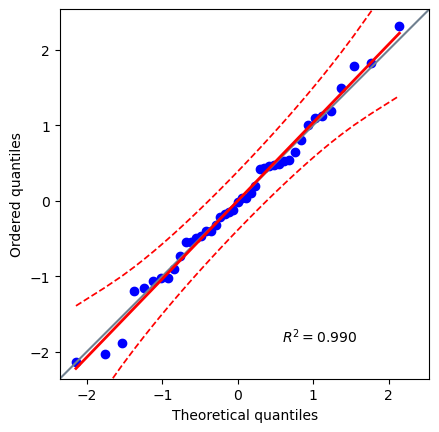

In [16]:
pg.qqplot(resid)

Figure 8: Q-Q Plot of Residuals

To test for equal variance, we plot the residuals against the fitted values for the model.

In [17]:
fitted_df = pd.DataFrame({
    "observed": y,
    "fitted": y - resid,
    "residuals": resid
})

alt.Chart(fitted_df).mark_point().encode(
    x=alt.X(
        "fitted",
        scale=alt.Scale(zero=False)
    ).title("Fitted Values"),
    y=alt.Y(
        "residuals",
        scale=alt.Scale(zero=False)
    ).title("Residuals")
)

alt.Chart(...)

Figure 9: Residuals vs Fitted Values

## DISCUSSION

### Summary of Findings

The objective of this analysis was to determine if a linear relationship exists between serum C-peptide (log-transformed concentration, pmol/ml) and the factors of patient age (Age, years) and base deficit ($\text{Deficit}$, mEq/L) in children with insulin-dependent diabetes mellitus.

A multiple linear regression model yielded the following key findings (Figure 6):

**Statistical Significance:** Both predictor variables, Age ($p=0.0066$) and Deficit ($p=0.0034$), were found to be statistically significant in predicting the $\text{C-peptide}$ level (using a typical $\alpha = 0.05$).

**Direction and Magnitude of Association:**
Age has a positive coefficient ($\text{coef} = 0.066$), indicating that for every one-year increase in age, the log $\text{C-peptide}$ concentration is expected to increase by 0.066 units, holding $\text{Deficit}$ constant.

**Base Deficit** has a positive coefficient ($\text{coef} = 0.041$), meaning that for every one $\text{mEq/L}$ increase in $\text{Deficit}$, the log $\text{C-peptide}$ concentration is expected to increase by 0.041 units, holding $\text{Age}$ constant. (Note: Since $\text{Deficit}$ values are negative, an increase (closer to 0) signifies less severe metabolic acidosis.)

**Model Fit:** The model achieved an adjusted $R^2$ of 0.337. This means that approximately 33.7% of the variance in the log $\text{C-peptide}$ concentration is explained by the patient's age and base deficit.

**Model Assumptions:** The diagnostic tests (Shapiro-Wilk $p = 0.927$ and Q-Q plot/Residuals vs. Fitted plot, Figures 7-9) indicate that the key linear regression assumptions of normally distributed residuals and homoscedasticity (equal variance) are reasonably met.